# EXPLORATION_DJ
# E05 Spectrogram Classification

###  *2차원 Spectrogram 데이터를 입력받아 위 모델과 동일한 역할을 수행하는 모델
### *기본 버전과 Skip-connection 버전으로 나누어 각각 진행하기

## 학습 목표  
*Audio 형태의 데이터를 다루는 방법에 대해서 알아보기  
*Wav 파일의 형태와 원리를 이해하기  
*오디오데이터를 다른 다양한 형태로 변형시켜보기  
*차원이 다른 데이터에 사용가능한 classification 모델 직접 제작해보기  


## Spectrogram  
다양한 파형들을 그 주파
수 대역별로 나누어 별도로 해석해볼 수 있는 방법  

**푸리에 변환(Fourier transform)**
임의의 입력 신호를 다양한 주파수를 갖는 주기함수 (복수 지수함수)들이 합으로 분해하여 표현

**Spectrogram이란?**  
wav 데이터를 해석하는 방법 중 하나로, 일정 시간동안 wav 데이터 안의 다양한 주파수들이 얼마나 포함되어 있는지  
이 Spectrogram을 그리는 방법이 바로 위에 소개한 STFT입니다.

X축은 시간, Y축은 주파수를 나타내며, 해당 시간/주파수에서의 음파 강도에 따라 밝은색으로 표현됩니다.  
wav 데이터가 단위 시간만큼 Short Time Fourier Transform을 진행해 매 순간의 주파수 데이터들을 얻어서 Spectrogram을 완성합니다.  

Step2에서 사용한 샘플데이터를 이용하여 스펙트로그램을 생성해 봅시다.  

먼저 파이썬에서 제공하는 FFT 관련 라이브러리인 librosa를 설치합니다.  

## Spectrogram classification 모델 구현  

오늘 실습에서 1차원 Waveform 데이터를 입력받아 Text 라벨을 출력하는 모델을 기본 버전과 Skip-connection 버전으로 나누어 학습시켜 보았습니다.  
이번에는 2차원 Spectrogram 데이터를 입력받아 위 모델과 동일한 역할을 수행하는 모델을 아래 제시된 단계와 같이 수행해 보시기 바랍니다.  
이번에도 마찬가지로 기본 버전과 Skip-connection 버전으로 나누어 각각 진행해 보시기 바랍니다.  
모델 구조를 제외하고는 실습에서 제시된 것과 거의 동일하게 진행될 것입니다. 

**1. 데이터 처리와 분류**  

* 라벨 데이터 처리하기  
* sklearn의 train_test_split함수를 이용하여 train, test 분리  

In [1]:
import numpy as np
import os
from tensorflow.keras import layers
import tensorflow as tf
import librosa
import librosa.display
import matplotlib.pyplot as plt
from abc import *
from pathlib import Path


#음성 data 로드
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [2]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [3]:
#Wave 데이터를 Spectrogram으로 변환하기
spec = []
for wav in speech_data["wav_vals"]:
    spec.append(wav2spec(wav))
spec = np.array(spec)

#spec = wav2spec(data)
#print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Spectrogram shape :  (50620, 130, 126)


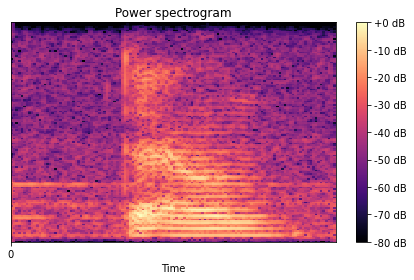

(50620, 130, 126)


In [4]:
import librosa.display
#전체 Spectrogram을 그릴 경우 커널이 죽는 현상이 발생하여 일부만 그려서 확인
# librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
librosa.display.specshow(librosa.amplitude_to_db(spec[20], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

print(spec.shape)

In [5]:
#라벨 데이터 만들기
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

#Text로 이루어진 라벨 데이터를 학습에 사용하기 위해서 index 형태로 바꿔주는 작업  
#int로 이뤄진 index 작업을 통해서 Label data를 더 쉽게 사용
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value
print(len(label_value))

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
12
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [6]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data
#label_data.shape

array([ 3,  3,  3, ..., 11, 11, 11])

**학습을 위한 데이터 분리**  
sklearn의 train_test_split 함수를 이용해 train data와 test data를 분리  
test_size의 인자를 조절해주면, 설정해 준 값만큼 Test dataset의 비율을 조정

In [7]:
from sklearn.model_selection import train_test_split

#sr = 8000
train_spec, test_spec, train_label, test_label = train_test_split(spec, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_spec)


# train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
# test_wav = test_wav.reshape([-1, sr, 1])
print("====================================")
print("train data : ", train_spec.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_spec.shape)
print("test labels : ", test_label.shape)
print("✅")

[[[1.01520550e+00 8.98748279e-01 7.49208570e-01 ... 1.13818753e+00
   1.00636733e+00 1.00563323e+00]
  [6.29815817e-01 3.92438382e-01 4.66184378e-01 ... 6.42089128e-01
   4.19237822e-01 5.73692977e-01]
  [1.58002779e-01 1.57204613e-01 1.97992131e-01 ... 1.79544449e-01
   1.48728147e-01 7.51625001e-02]
  ...
  [7.26310816e-03 3.67389154e-03 3.11878307e-06 ... 1.93437445e-05
   6.80052181e-05 5.12600309e-05]
  [7.21262954e-03 3.64577980e-03 5.73622310e-06 ... 1.65629463e-05
   5.14531093e-05 5.28271739e-05]
  [7.19124964e-03 3.63402767e-03 2.82628662e-06 ... 1.08467921e-05
   5.68563883e-05 9.01092135e-05]]

 [[7.01327696e-02 1.15425438e-01 4.12081182e-02 ... 2.38729734e-02
   4.43325341e-02 1.65939573e-02]
  [1.80511940e-02 2.04674423e-01 4.00989026e-01 ... 2.35901147e-01
   3.26153606e-01 2.51751244e-01]
  [4.99075592e-01 5.57681143e-01 6.02575421e-01 ... 2.20095858e-01
   5.64289391e-01 9.41639423e-01]
  ...
  [2.49452263e-01 1.31004319e-01 2.04077493e-02 ... 2.25520991e-02
   2.20316

In [8]:
spec[0].shape

(130, 126)

In [9]:
#커널이 죽는 것을 막기위해 메모리 정리
del speech_data
del spec

**2. 학습을 위한 하이퍼파라미터 설정**  

In [10]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir2 = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec2'

checkpoint_dir1 = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec1'

checkpoint_dir2
checkpoint_dir1

'/home/aiffel-dj56/aiffel/speech_recognition/models/spec1'

**3. 데이터셋 구성**  
* `tf.data.Dataset`을 이용  
* from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용  
* map과 batch를 이용한 데이터 전처리  
* 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.  
`tf.data.Dataset`이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.

`del speech_data`
`del spec_data`

In [11]:
def one_hot_label(spec, label):
    label = tf.one_hot(label, depth=12)
    return spec, label
print("✅")

✅


In [12]:
#tf.data.Dataset 함수를 구성. 
#batch는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")



<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
✅


**4. 2차원 Spectrogram 데이터를 처리하는 모델 구성**  
* 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
* batchnorm, dropout, dense layer 등을 이용
* 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
* 모델 가중치를 저장하는 checkpoint callback 함수 추가
* 다양한 모델의 실험을 진행해 보시기 바랍니다.  

In [13]:
from tensorflow.keras import layers

#Conv2D layer 모델
                            #spec 형태 130, 126 
input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_2 = tf.keras.Model(input_tensor, output_tensor)
model_2.summary()


#skip-connection 버전 모델
                            #spec 형태 130, 126 
input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(skip_3)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_1 = tf.keras.Model(input_tensor, output_tensor)
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

**5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력**  
* loss, accuracy를 그래프로 표현  

In [14]:
#Conv2D layer 모델 컴파일
optimizer=tf.keras.optimizers.Adam(1e-4)
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [15]:
# #skip-connection 모델 컴파일
optimizer=tf.keras.optimizers.Adam(1e-4)
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [16]:
#모델 체크포인트 저장
cp_callback2 = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir2,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [17]:
#30분 내외 소요
#max_epochs = 5
history_spec2 = model_2.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback2]
                    )
print("✅")

Epoch 1/10
1422/1423 [============================>.] - ETA: 0s - loss: 0.7422 - accuracy: 0.7629
Epoch 00001: val_loss improved from inf to 0.29483, saving model to /home/aiffel-dj56/aiffel/speech_recognition/models/spec2
1423/1423 [==============================] - 61s 43ms/step - loss: 0.7419 - accuracy: 0.7630 - val_loss: 0.2948 - val_accuracy: 0.9068
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.9195
Epoch 00002: val_loss improved from 0.29483 to 0.22937, saving model to /home/aiffel-dj56/aiffel/speech_recognition/models/spec2
1423/1423 [==============================] - 61s 43ms/step - loss: 0.2620 - accuracy: 0.9195 - val_loss: 0.2294 - val_accuracy: 0.9276
Epoch 3/10
1422/1423 [============================>.] - ETA: 0s - loss: 0.1676 - accuracy: 0.9490
Epoch 00003: val_loss improved from 0.22937 to 0.18135, saving model to /home/aiffel-dj56/aiffel/speech_recognition/models/spec2
1423/1423 [==============================] - 61s 43ms

In [18]:
#모델 체크포인트 저장
cp_callback1 = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir1,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [19]:
history_spec1 = model_1.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback1]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.8972 - accuracy: 0.7179
Epoch 00001: val_loss improved from inf to 0.36344, saving model to /home/aiffel-dj56/aiffel/speech_recognition/models/spec1
1423/1423 [==============================] - 59s 41ms/step - loss: 0.8972 - accuracy: 0.7179 - val_loss: 0.3634 - val_accuracy: 0.8912
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.3207 - accuracy: 0.9048
Epoch 00002: val_loss improved from 0.36344 to 0.25843, saving model to /home/aiffel-dj56/aiffel/speech_recognition/models/spec1
1423/1423 [==============================] - 59s 41ms/step - loss: 0.3207 - accuracy: 0.9048 - val_loss: 0.2584 - val_accuracy: 0.9179
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9457
Epoch 00003: val_loss improved from 0.25843 to 0.21198, saving model to /home/aiffel-dj56/aiffel/speech_recognition/models/spec1
1423/1423 [==============================] - 59s 41ms

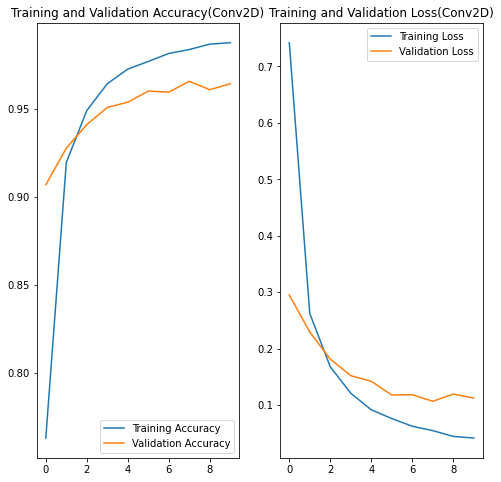

✅


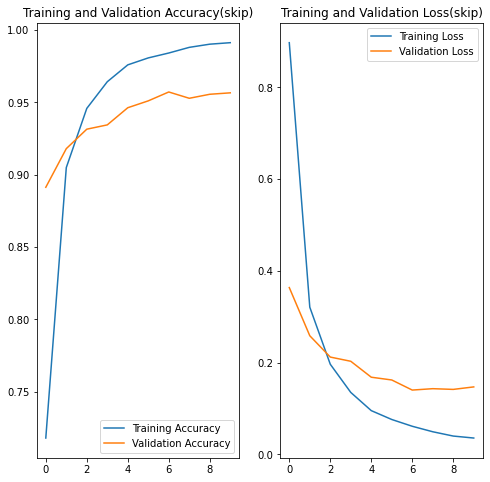

✅


In [20]:
import matplotlib.pyplot as plt

#Conv2D layer 모델
acc = history_spec2.history['accuracy']
val_acc = history_spec2.history['val_accuracy']

loss=history_spec2.history['loss']
val_loss=history_spec2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy(Conv2D)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss(Conv2D)')
plt.show()
print("✅")

#skip-connection 버전 모델
acc = history_spec1.history['accuracy']
val_acc = history_spec1.history['val_accuracy']

loss=history_spec1.history['loss']
val_loss=history_spec1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy(skip)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss(skip)')
plt.show()
print("✅")

**6. Test dataset을 이용해서 모델의 성능을 평가**  
* 저장한 weight 불러오기
* 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [21]:
# Evaluation 
model_2.load_weights(checkpoint_dir2)
results2 = model_2.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results2[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results2[1]*100))
print("✅")

model_1.load_weights(checkpoint_dir1)
results1 = model_1.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results1[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results1[1]*100))
print("✅")

159/159 [==============================] - 28s 177ms/step - loss: 0.1065 - accuracy: 0.9656
loss value: 0.106
accuracy value: 96.5626%
✅
159/159 [==============================] - 6s 35ms/step - loss: 0.1399 - accuracy: 0.9571
loss value: 0.140
accuracy value: 95.7132%
✅


In [40]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_2 = model_2(batch_xs, training=False)

print("label 2 : ", str(inv_label_value[batch_ys[0]]))


inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_1 = model_1(batch_xs, training=False)

print("label 1 : ", str(inv_label_value[batch_ys[0]]))


label 2 :  down
label 1 :  down


In [41]:
if np.argmax(y_pred_2) == batch_ys[0]:
    print("y_pred 2: " + str(inv_label_value[np.argmax(y_pred_2)]) + '(Correct!)')
else:
    print("y_pred 2: " + str(inv_label_value[np.argmax(y_pred_2)]) + '(Incorrect!)')
print("✅")


if np.argmax(y_pred_1) == batch_ys[0]:
    print("y_pred 1: " + str(inv_label_value[np.argmax(y_pred_1)]) + '(Correct!)')
else:
    print("y_pred 1: " + str(inv_label_value[np.argmax(y_pred_1)]) + '(Incorrect!)')
print("✅")

y_pred 2: down(Correct!)
✅
y_pred 1: down(Correct!)
✅


## ◈ 용어 사전 및 설명

`푸리에변환 (Fourier transform)`  
임의의 입력 신호를 다양한 주파수를 갖는 주기함수 (복수 지수함수)들이 합으로 분해하여 표현하는 것

## ◈ 결과
GPU를 사용하면서 한 번에 코드를 수행하기 어려웠다.   
커널이 자꾸 다운되어서 문제가 많았다.  
여러 번 시도한 끝에 96%이상의 좋은 정확도를 얻을 수 있었다. 


## 루브릭

평가문항/상세기준  
1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.  
스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.  

2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.  
스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.  

3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.  
evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.  